PREPARED BY Tathagata Mookherjee<br>
ROLL NUMBER - M21AI619<br>
DATE : 26/03/2022<br>
Machine Learning Fractal 2, Programming Assignment<br>
IIT JODHPUR<br>
<br>
Question 2:<br>
Implement the Principal Component Analysis algorithm for reducing the dimensionality of the points given in the datasets: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data. Each point of this dataset is a 4-dimensional vector (d = 4) given in the first column of the datafile. Reduce the dimensionality to 2 (k = 2). This dataset contains 3 clusters. Ground-truth cluster IDs are given as the fifth column of the data file. In order to evaluate the performance of the PCA algorithm, perform clustering (in 3 clusters) before and after dimensionality reduction using the Spectral Clustering algorithm and then find the percentage of points for which the estimated cluster label is correct. Report the accuracy of the Spectral Clustering algorithm before and after the dimensionality reduction. Report the reconstruction error for k = 1, 2, 3. [15 Marks]<br>

Solution:<br>
<br>
First we import the dataset and observe the same<br>

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

random.seed(1)
np.random.seed(1)

cluster_no = 2
allowed_error=0

var_df_file = pd.read_csv('M21AI619_PA2_Q2.csv', names=['sepal_length','sepal_width','petal_length','petal_width','target'])
var_df_file.head()


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Now we create the KMeans algorithm functions

In [153]:
def getInitCentroids(var_data_points, cluster_no):
    number_of_samples = var_data_points.shape[0]
    var_rand_mu = random.sample(range(0, number_of_samples), cluster_no)
    var_centroids = [tuple(var_data_points[id]) for id in var_rand_mu]
    var_unique_centroids = list(set(var_centroids))
    var_unique_centroids_count = len(var_unique_centroids)

    while var_unique_centroids_count < cluster_no:
        var_rand_mu_new = random.sample(range(0, number_of_samples), cluster_no - var_unique_centroids_count)
        new_centroids = [tuple(var_data_points[id]) for id in var_rand_mu_new]
        var_unique_centroids = list(set(var_unique_centroids + new_centroids))
        var_unique_centroids_count = len(var_unique_centroids)

    return np.array(var_unique_centroids)

def getDist(var_tmp1, var_tmp2):
    var_tmp1_sq = np.reshape(np.sum(var_tmp1 * var_tmp1, axis=1), (var_tmp1.shape[0], 1))
    var_tmp2_sq = np.reshape(np.sum(var_tmp2 * var_tmp2, axis=1), (1, var_tmp2.shape[0]))
    var_dot=np.dot(var_tmp1,var_tmp2.T)
    var_dist = np.sqrt(-2 * var_dot + var_tmp2_sq + var_tmp1_sq)

    return var_dist

def getClusters(var_data_points, centroids):
    cluster_no = centroids.shape[0]
    cluster_count=np.zeros(0)
    clusters = {}
    distance_matrix = getDist(var_data_points, centroids)
    closest_cluster_ids = np.argmin(distance_matrix, axis=1)
    for i in range(cluster_no):
        clusters[i] = []
    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(var_data_points[i])
        cluster_count = np.append(cluster_count, cluster_id)
    return clusters, cluster_count

def checkCentroids(previous_centroids, new_centroids, allowed_error):
    distances_between_old_and_new_centroids = getDist(previous_centroids, new_centroids)
    centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= allowed_error
    return centroids_covered

def getKmeans(var_data_points, cluster_no,allowed_error):
    new_centroids = getInitCentroids(var_data_points=var_data_points, cluster_no=cluster_no)

    centroids_covered = False
    while not centroids_covered:
        previous_centroids = new_centroids
        clusters, _ = getClusters(var_data_points, previous_centroids)
        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=var_data_points.dtype) for key in sorted(clusters.keys())])
        centroids_covered = checkCentroids(previous_centroids, new_centroids, allowed_error)

    return new_centroids

Now we create the Spectral clustering Function

In [154]:
def getSpectral(var_data_points, cluster_no):
    #hyper parameters
    lamda=76
    sigmasq=10

    #finding the weight matrix
    var_weight_matrix = np.exp(-(lamda/sigmasq) * getDist(var_data_points, var_data_points))

    #finding diagonal matrix
    var_diagonal_matrix = np.diag(var_weight_matrix.sum(axis=1))

    #finding laplacian matrix
    var_laplacian_matrix =  var_diagonal_matrix - var_weight_matrix

    #finding eigen values and vectors
    var_eig_values, var_eig_vectors = np.linalg.eig(var_laplacian_matrix)

    #picking the top eigen values based on the cluster number 
    var_eig_values_sorted = np.argsort(var_eig_values)[:2]

    #picking the eigen vectors as per the above eigen values
    var_H_matrix=var_eig_vectors[:,var_eig_values_sorted]

    #perform usual K-Means clustering using H matrix
    var_centroids = getKmeans(var_H_matrix, cluster_no, allowed_error)
    var_clusters, cluster_count = getClusters(var_H_matrix, var_centroids)
    
    return var_centroids, var_clusters, cluster_count

Now we create the PCA function

In [155]:
def PCA(var_data_points , cluster_no):
     
    #Step-1
    var_data_points_meaned = var_data_points - np.mean(var_data_points , axis = 0)
     
    #Step-2
    cov_mat = np.cov(var_data_points_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_eigenvalue = np.argsort(eigen_values)[::-1]
    sorted_eigenvectors = eigen_vectors[:,sorted_eigenvalue]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:cluster_no]
     
    #Step-6
    var_data_points_reduced = np.dot(eigenvector_subset.transpose() , var_data_points_meaned.transpose() ).transpose()
     
    return var_data_points_reduced

From the dataset we can see that,<br>
<br>
1. There are 50 instances of Iris-setosa<br>
2. There are 50 instances of Iris-versicolor<br>
2. There are 50 instances of Iris-virginica<br>

We shall be running the PCA algorithm and then feeding to Spectral Clustering (which uses K-Means)<br>

We shall run the below configuration<br>
<br>
1. Clusters=3<br>
2. Principal Components=None<br>

Accuracy for cluster 1 is: 4.0%
Accuracy for cluster 2 is: 100%
Accuracy for cluster 3 is: 100%
Average Accuracy is: 68.0%


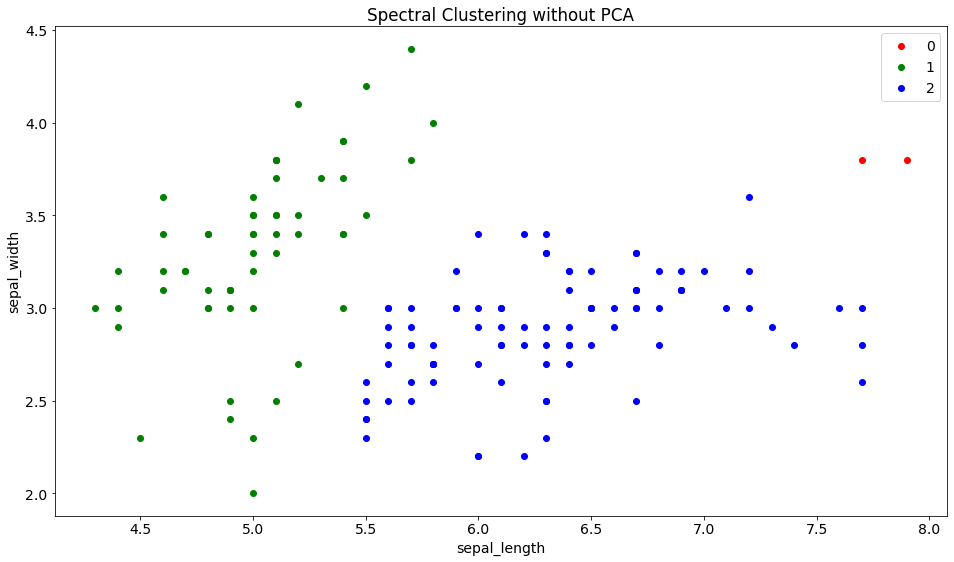

In [167]:
cluster_no=3
# prepare the data
var_data_points = var_df_file.iloc[:,0:2]
 
_, _, cluster_count =getSpectral(var_data_points.to_numpy(), cluster_no)

#we find the actual clustering and compare against ground truth
category0_out=0
category1_out=0
category2_out=0
for i in range(len(cluster_count)):
    temp = cluster_count[i]
    if temp == 0:
        category0_out = category0_out+1
    if temp == 1:
        category1_out = category1_out+1
    if temp == 2:
        category2_out = category2_out+1

category0_accuracy=category0_out/50*100
if category0_accuracy > 100:
    category0_accuracy = 100

category1_accuracy=category1_out/50*100
if category1_accuracy > 100:
    category1_accuracy = 100

category2_accuracy=category2_out/50*100
if category2_accuracy > 100:
    category2_accuracy = 100

total_accuracy = (category0_accuracy+category1_accuracy+category2_accuracy)/3

print('Accuracy for cluster 1 is: '+str(category0_accuracy)+'%')
print('Accuracy for cluster 2 is: '+str(category1_accuracy)+'%')
print('Accuracy for cluster 3 is: '+str(category2_accuracy)+'%')
print('Average Accuracy is: '+str(total_accuracy)+'%')

var_data_points = np.append(var_data_points, np.transpose([cluster_count]), axis = 1)
axisFields = pd.DataFrame(var_data_points, columns = ['sepal_length', 'sepal_width','Cluster'])


plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
# Plot PCA with Spectral Clustering result
color=['red','green', 'blue']
for k in range(3):
    dataset = axisFields[axisFields["Cluster"]==k]
    plt.scatter(dataset["sepal_length"],dataset["sepal_width"],c=color[k], label = k )
plt.title('Spectral Clustering without PCA')    
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()


We shall run the below configuration<br>
<br>
1. Clusters=3<br>
2. Principal Components=3<br>

Accuracy for cluster 1 is: 100.0%
Accuracy for cluster 2 is: 100%
Accuracy for cluster 3 is: 8.0%
Average Accuracy is: 69.33333333333333%


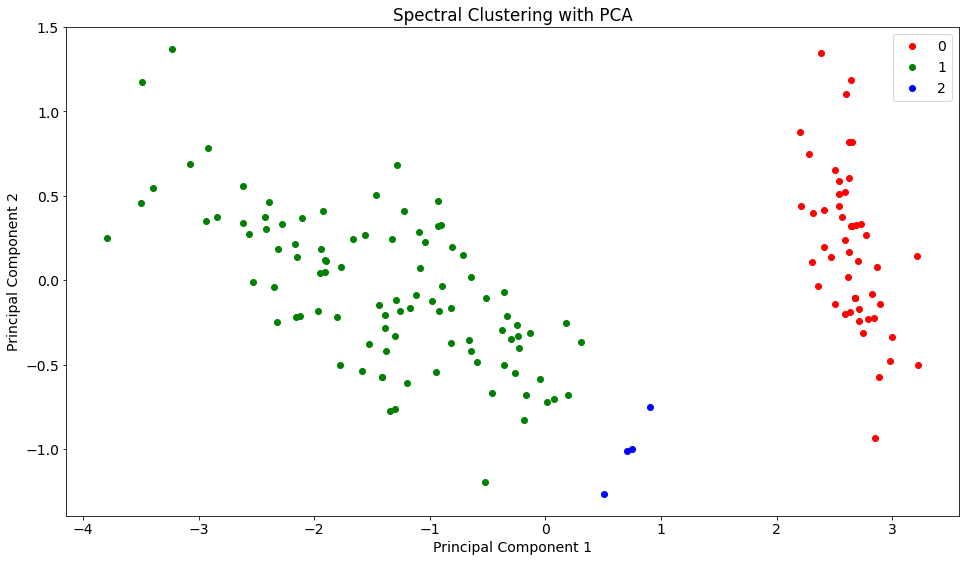

In [172]:
cluster_no=3

PC_comps=3
# prepare the data
var_data_points = var_df_file.iloc[:,0:4]
 
# prepare the target
var_target = var_df_file.iloc[:,4]
 
# Applying it to PCA function
var_PCA = PCA(var_data_points , PC_comps)

 
# Creating a Pandas DataFrame of reduced Dataset
var_PCA_Reduced = pd.DataFrame(var_PCA , columns = ['PC1','PC2','PC3'])

 
# Concat it with target variable to create a complete Dataset
var_data_points_PCA = pd.concat([var_PCA_Reduced , pd.DataFrame(var_target)] , axis = 1)
var_data_points_Reduced = var_data_points_PCA[['PC1', 'PC2', 'PC3']].to_numpy()

_, _, cluster_count =getSpectral(var_data_points_Reduced, cluster_no)

#we find the actual clustering and compare against ground truth
category0_out=0
category1_out=0
category2_out=0
for i in range(len(cluster_count)):
    temp = cluster_count[i]
    if temp == 0:
        category0_out = category0_out+1
    if temp == 1:
        category1_out = category1_out+1
    if temp == 2:
        category2_out = category2_out+1

category0_accuracy=category0_out/50*100
if category0_accuracy > 100:
    category0_accuracy = 100

category1_accuracy=category1_out/50*100
if category1_accuracy > 100:
    category1_accuracy = 100

category2_accuracy=category2_out/50*100
if category2_accuracy > 100:
    category2_accuracy = 100

total_accuracy = (category0_accuracy+category1_accuracy+category2_accuracy)/3

print('Accuracy for cluster 1 is: '+str(category0_accuracy)+'%')
print('Accuracy for cluster 2 is: '+str(category1_accuracy)+'%')
print('Accuracy for cluster 3 is: '+str(category2_accuracy)+'%')
print('Average Accuracy is: '+str(total_accuracy)+'%')

var_data_points_PCA = np.append(var_data_points_PCA, np.transpose([cluster_count]), axis = 1)
axisFields = pd.DataFrame(var_data_points_PCA, columns = ['PC1', 'PC2','PC3', 'target','Cluster'])

plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
# Plot PCA with Spectral Clustering result
color=['red','green', 'blue']
for k in range(3):
    dataset = axisFields[axisFields["Cluster"]==k]
    plt.scatter(dataset["PC1"],dataset["PC2"],c=color[k], label = k )
plt.title('Spectral Clustering with PCA')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


After implementing PCA we can see that PCA = 3 shows a 4% improvement in categorization of the data.

We shall run the below configuration<br>
<br>
1. Clusters=3<br>
2. Principal Components=2<br>

C:\Users\no\AppData\Local\Temp\ipykernel_10384\2357089098.py:20: RuntimeWarning: invalid value encountered in sqrt
  var_dist = np.sqrt(-2 * var_dot + var_tmp2_sq + var_tmp1_sq)


Accuracy for cluster 1 is: 80.0%
Accuracy for cluster 2 is: 20.0%
Accuracy for cluster 3 is: 100%
Average Accuracy is: 66.66666666666667%


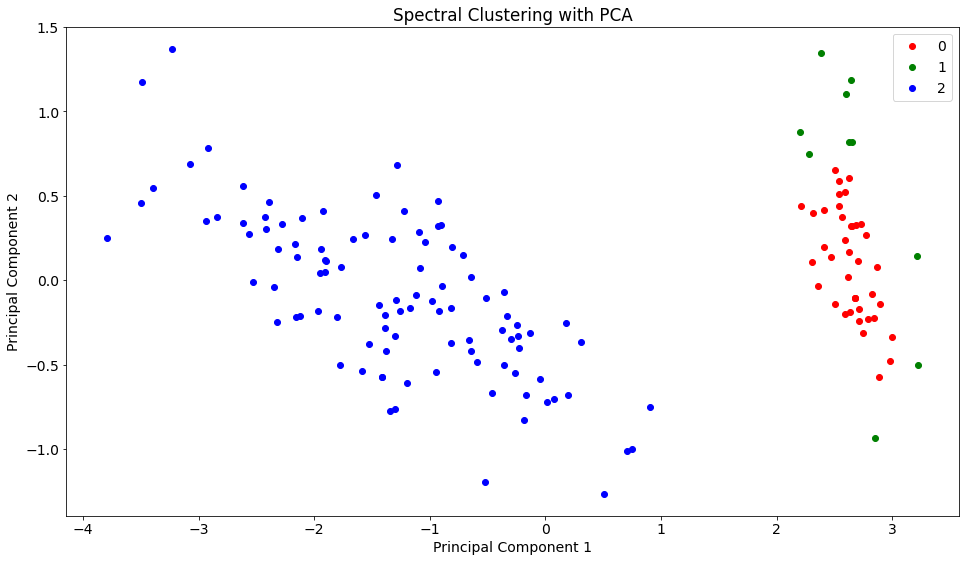

In [173]:
cluster_no=3

PC_comps=2
# prepare the data
var_data_points = var_df_file.iloc[:,0:4]
 
# prepare the target
var_target = var_df_file.iloc[:,4]
 
# Applying it to PCA function
var_PCA = PCA(var_data_points , PC_comps)

 
# Creating a Pandas DataFrame of reduced Dataset
var_PCA_Reduced = pd.DataFrame(var_PCA , columns = ['PC1','PC2'])

 
# Concat it with target variable to create a complete Dataset
var_data_points_PCA = pd.concat([var_PCA_Reduced , pd.DataFrame(var_target)] , axis = 1)
var_data_points_Reduced = var_data_points_PCA[['PC1', 'PC2']].to_numpy()

_, _, cluster_count =getSpectral(var_data_points_Reduced, cluster_no)

#we find the actual clustering and compare against ground truth
category0_out=0
category1_out=0
category2_out=0
for i in range(len(cluster_count)):
    temp = cluster_count[i]
    if temp == 0:
        category0_out = category0_out+1
    if temp == 1:
        category1_out = category1_out+1
    if temp == 2:
        category2_out = category2_out+1

category0_accuracy=category0_out/50*100
if category0_accuracy > 100:
    category0_accuracy = 100

category1_accuracy=category1_out/50*100
if category1_accuracy > 100:
    category1_accuracy = 100

category2_accuracy=category2_out/50*100
if category2_accuracy > 100:
    category2_accuracy = 100

total_accuracy = (category0_accuracy+category1_accuracy+category2_accuracy)/3

print('Accuracy for cluster 1 is: '+str(category0_accuracy)+'%')
print('Accuracy for cluster 2 is: '+str(category1_accuracy)+'%')
print('Accuracy for cluster 3 is: '+str(category2_accuracy)+'%')
print('Average Accuracy is: '+str(total_accuracy)+'%')

var_data_points_PCA = np.append(var_data_points_PCA, np.transpose([cluster_count]), axis = 1)
axisFields = pd.DataFrame(var_data_points_PCA, columns = ['PC1', 'PC2', 'target','Cluster'])

plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
# Plot PCA with Spectral Clustering result
color=['red','green', 'blue']
for k in range(3):
    dataset = axisFields[axisFields["Cluster"]==k]
    plt.scatter(dataset["PC1"],dataset["PC2"],c=color[k], label = k )
plt.title('Spectral Clustering with PCA')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


We shall run the below configuration<br>
<br>
1. Clusters=3<br>
2. Principal Components=1<br>

Accuracy for cluster 1 is: 100.0%
Accuracy for cluster 2 is: 8.0%
Accuracy for cluster 3 is: 100%
Average Accuracy is: 69.33333333333333%


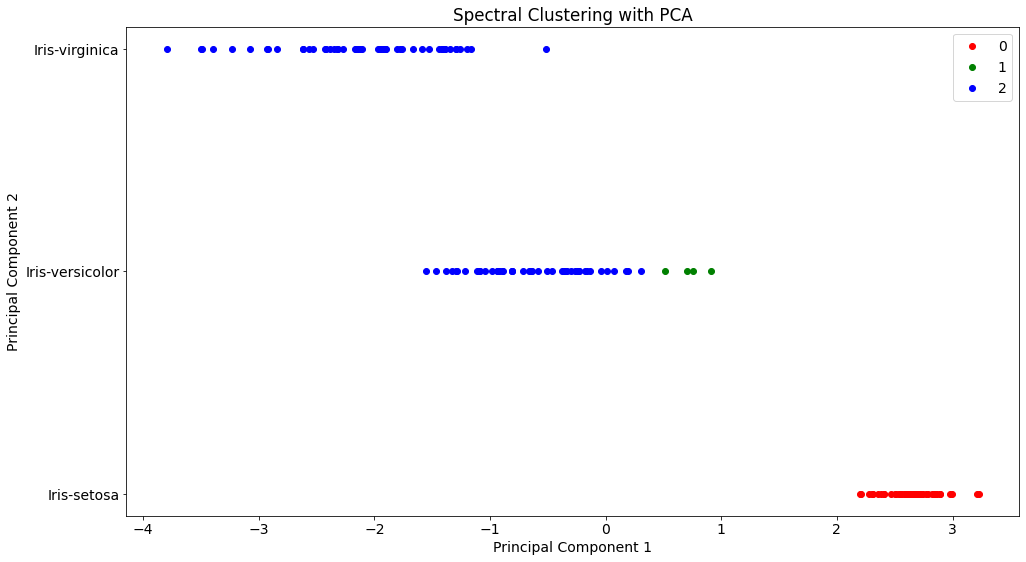

In [175]:
cluster_no=3

PC_comps=1
# prepare the data
var_data_points = var_df_file.iloc[:,0:4]
 
# prepare the target
var_target = var_df_file.iloc[:,4]
 
# Applying it to PCA function
var_PCA = PCA(var_data_points , PC_comps)

 
# Creating a Pandas DataFrame of reduced Dataset
var_PCA_Reduced = pd.DataFrame(var_PCA , columns = ['PC1'])

 
# Concat it with target variable to create a complete Dataset
var_data_points_PCA = pd.concat([var_PCA_Reduced , pd.DataFrame(var_target)] , axis = 1)
var_data_points_Reduced = var_data_points_PCA[['PC1']].to_numpy()

_, _, cluster_count =getSpectral(var_data_points_Reduced, cluster_no)

#we find the actual clustering and compare against ground truth
category0_out=0
category1_out=0
category2_out=0
for i in range(len(cluster_count)):
    temp = cluster_count[i]
    if temp == 0:
        category0_out = category0_out+1
    if temp == 1:
        category1_out = category1_out+1
    if temp == 2:
        category2_out = category2_out+1

category0_accuracy=category0_out/50*100
if category0_accuracy > 100:
    category0_accuracy = 100

category1_accuracy=category1_out/50*100
if category1_accuracy > 100:
    category1_accuracy = 100

category2_accuracy=category2_out/50*100
if category2_accuracy > 100:
    category2_accuracy = 100

total_accuracy = (category0_accuracy+category1_accuracy+category2_accuracy)/3

print('Accuracy for cluster 1 is: '+str(category0_accuracy)+'%')
print('Accuracy for cluster 2 is: '+str(category1_accuracy)+'%')
print('Accuracy for cluster 3 is: '+str(category2_accuracy)+'%')
print('Average Accuracy is: '+str(total_accuracy)+'%')

var_data_points_PCA = np.append(var_data_points_PCA, np.transpose([cluster_count]), axis = 1)
axisFields = pd.DataFrame(var_data_points_PCA, columns = ['PC1', 'target','Cluster'])

plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
# Plot PCA with Spectral Clustering result
color=['red','green', 'blue']
for k in range(3):
    dataset = axisFields[axisFields["Cluster"]==k]
    plt.scatter(dataset["PC1"],dataset["target"],c=color[k], label = k )
plt.title('Spectral Clustering with PCA')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
